In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download("stopwords")
import string
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import time
start = time.time()

Using TensorFlow backend.


In [0]:

def load_data(path):
    data = pd.read_csv(path)
    x = data['reviewText'].tolist()
    y = data['sentiment'].tolist()
    return x, y


In [0]:
lemmatizer = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

In [0]:
def preprocessing(line):
    line = line.replace('<br />', '')   
    line = line.translate(transtbl)     
    
    
    tokens = []
    for t in nltk.word_tokenize(line):
        t = t.lower()
        if t not in stopwords:
            lemma = lemmatizer.lemmatize(t, 'v')
            tokens.append(lemma)
            
    return ' '.join(tokens)

In [0]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from keras.preprocessing import sequence

np.random.seed(1)

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving glove.6B.50d.txt to glove.6B.50d.txt
User uploaded file "glove.6B.50d.txt" with length 171350079 bytes


In [0]:
def read_glove_vec(glove_file):
    with open(glove_file, 'r', encoding='utf-8', errors='ignore') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        for w in sorted(words):
            words_to_index[w] = i
            i = i + 1
    return words_to_index, word_to_vec_map

In [0]:
word_to_index, word_to_vec_map = read_glove_vec('glove.6B.50d.txt')

In [0]:
from keras.preprocessing import sequence

In [12]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
train_x, train_y = load_data('train.csv')
test_x, test_y = load_data('test.csv')
train_x = [preprocessing(x) for x in train_x]
test_x = [preprocessing(x) for x in test_x]

In [14]:
train_y_ec = np.array([0 if x == 'neg' else 1 for x in train_y])
test_y_ec = np.array([0 if x == 'neg' else 1 for x in test_y])
print(train_y_ec)
print(test_y_ec)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]


In [0]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

tokenizer.fit_on_texts(train_x)

train_x_ec = tokenizer.texts_to_sequences(train_x)
test_x_ec = tokenizer.texts_to_sequences(test_x)

In [0]:
from keras.preprocessing.sequence import pad_sequences

Xtrain = pad_sequences(train_x_ec, maxlen=100, padding='post')
Xtest = pad_sequences(test_x_ec, maxlen=100, padding='post')

In [0]:
vocab_size = len(tokenizer.word_index) + 1

In [0]:
def load_embedding(filename):
	file = open(filename,'r',encoding='utf-8', errors='ignore')
	lines = file.readlines()
	file.close()
	
	embedding = dict()
	for line in lines:
		parts = line.split()
		embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
	return embedding

In [0]:
def get_weight_matrix(embedding, vocab):
	vocab_size = len(vocab) + 1
	weight_matrix = np.zeros((vocab_size, 50))
	for word, i in vocab.items():
		vector = embedding.get(word)
		if vector is not None:
			weight_matrix[i] = vector
	return weight_matrix

In [0]:
from keras.layers import Embedding, SpatialDropout1D
raw_embedding = load_embedding('glove.6B.50d.txt')
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_vectors], input_length=100, trainable=False)

In [21]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(SpatialDropout1D(0.4))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(20, activation='tanh'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
end = time.time()
print("Neural Network model trained in %f seconds" % (end-start))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Neural Network model trained in 441.153687 seconds


In [22]:
start = time.time()

history = lstm_model.fit(Xtrain, train_y_ec, batch_size=32, epochs = 250, verbose = 2)

end = time.time()
print("LSTM model trained in %f seconds" % (end-start))

Instructions for updating:
Use tf.cast instead.
Epoch 1/250
 - 121s - loss: 0.6786 - acc: 0.5652
Epoch 2/250
 - 118s - loss: 0.6546 - acc: 0.6147
Epoch 3/250
 - 121s - loss: 0.6252 - acc: 0.6591
Epoch 4/250
 - 119s - loss: 0.5816 - acc: 0.6980
Epoch 5/250
 - 119s - loss: 0.5471 - acc: 0.7226
Epoch 6/250
 - 118s - loss: 0.5277 - acc: 0.7355
Epoch 7/250
 - 118s - loss: 0.5120 - acc: 0.7472
Epoch 8/250
 - 118s - loss: 0.5029 - acc: 0.7559
Epoch 9/250
 - 120s - loss: 0.4924 - acc: 0.7644
Epoch 10/250
 - 119s - loss: 0.4843 - acc: 0.7660
Epoch 11/250
 - 120s - loss: 0.4783 - acc: 0.7706
Epoch 12/250
 - 119s - loss: 0.4668 - acc: 0.7786
Epoch 13/250
 - 120s - loss: 0.4591 - acc: 0.7814
Epoch 14/250
 - 119s - loss: 0.4535 - acc: 0.7881
Epoch 15/250
 - 118s - loss: 0.4528 - acc: 0.7894
Epoch 16/250
 - 119s - loss: 0.4445 - acc: 0.7926
Epoch 17/250
 - 119s - loss: 0.4416 - acc: 0.7931
Epoch 18/250
 - 118s - loss: 0.4317 - acc: 0.7997
Epoch 19/250
 - 118s - loss: 0.4318 - acc: 0.7972
Epoch 20/25

In [24]:
score,acc = lstm_model.evaluate(Xtest, test_y_ec, verbose = 2, batch_size = 32)
print("acc: %.2f" % (acc))

acc:  0.9211


In [0]:
h = history.history.copy()

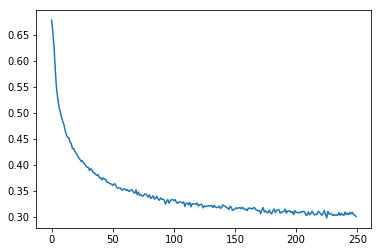

In [26]:
plt.plot(h['loss'])

In [27]:
sample = ["this movie is worst"]
sample_ec = tokenizer.texts_to_sequences(sample)
sample_ec_pad = pad_sequences(sample_ec, maxlen=100, padding='post')
sample_prediction = lstm_model.predict(sample_ec_pad)
result = "neg" if sample_prediction < 0.5 else "pos"
print ("the prediction result on the sample comment is: " + result)

the prediction result on the sample comment is: neg
